In [57]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.base import clone
from rfpimp import *

%matplotlib inline
pd.options.display.max_columns = 999

## 1. Feature Engineering

In [58]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    return df

In [216]:
def load_df(csv_path='GA_data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df

In [240]:
train = load_df('GA_data/train.csv')
test = load_df('GA_data/test.csv')

In [219]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [221]:
display_all(train.head())

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,go

### 1.1 Data Type Conversion

In [241]:
train = add_time_features(train)
test = add_time_features(test)
# Convert target feature to 'float' type.
train["transactionRevenue"] = train["transactionRevenue"].astype('float')
train['hits'] = train['hits'].astype(float)
test['hits'] = test['hits'].astype(float)
train['pageviews'] = train['pageviews'].astype(float)
test['pageviews'] = test['pageviews'].astype(float)

### 1.2 Data Aggregation using 'Pandas Group By'

In [242]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

In [243]:
# Drop stange 'dict' column
train = train.drop(['adwordsClickInfo'], axis=1)
test = test.drop(['adwordsClickInfo'], axis=1)
# Drop column that exists only in train data
train = train.drop(['campaignCode'], axis=1)
# Input missing transactionRevenue values
train["transactionRevenue"].fillna(0, inplace=True)
test_ids = test["fullVisitorId"].values

In [244]:
# Unwanted columns
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 
                    'browser', 'browserSize', 'browserVersion', 'flashVersion', 
                    'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                    'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 
                    'metro','networkDomain', 'networkLocation', 'adContent', 'campaign', ''
                    'isTrueDirect', 'keyword', 'referralPath', 'source', 'operatingSystem', 'day','country','city']

train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)
# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Columns with more than 50% null data
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

Columns with constant values:  ['socialEngagementType', 'language', 'mobileDeviceBranding', 'screenResolution', 'cityId', 'latitude', 'longitude', 'bounces', 'newVisits', 'visits']
Columns more than 50% null values:  []


In [245]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 19
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'continent' 'region' 'subContinent'
 'hits' 'pageviews' 'transactionRevenue' 'medium' 'year' 'month' 'weekday' 'mean_hits_per_day'
 'mean_pageviews_per_day' 'sum_hits_per_day' 'sum_pageviews_per_day']

TEST SET
Rows: 804684
Columns: 18
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'continent' 'region' 'subContinent'
 'hits' 'pageviews' 'medium' 'year' 'month' 'weekday' 'mean_hits_per_day' 'mean_pageviews_per_day'
 'sum_hits_per_day' 'sum_pageviews_per_day']


In [246]:
categorical_features = ['deviceCategory', 'isMobile', 'continent', 'month', 'weekday','channelGrouping','medium']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [247]:
# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

In [248]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 150000  # same as Kaggle's test set size
n_trn = len(train)-n_valid
raw_train, raw_valid = split_vals(train, n_trn)
X_train, X_val = split_vals(train, n_trn)
#Y_train, Y_val = split_vals(y, n_trn)

#X_train.shape, y_train.shape, X_valid.shape

In [231]:
x_train = X_train
x_val = X_val

In [294]:
x_train.to_csv('ga_train.csv')
x_val.to_csv('ga_val.csv')

In [188]:
X_train = train[train['date']<=datetime.date(2017, 3, 31)]
X_val = train[train['date']>datetime.date(2017, 5, 31)]

In [249]:
# Get labels
Y_train = X_train['transactionRevenue'].values
Y_val = X_val['transactionRevenue'].values
X_train = X_train.drop(['transactionRevenue'], axis=1)
X_val = X_val.drop(['transactionRevenue'], axis=1)
test = test.drop(['transactionRevenue'], axis=1)
# Log transform the labels
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [16]:
X_train.head()

,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,continent_(not set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,date,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,hits,isMobile_False,isMobile_True,mean_hits_per_day,mean_pageviews_per_day,medium_(none),medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,pageviews,region,subContinent,sum_hits_per_day,sum_pageviews_per_day,visitNumber,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,year
0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2016-09-02,1,0,0,1.0,1,0,3.943076,3.371298,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,Izmir,Western Asia,83747.0,71603.0,1,0,0,0,0,1,0,0,2016
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2016-09-02,1,0,0,1.0,1,0,3.943076,3.371298,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,not available in demo dataset,Australasia,83747.0,71603.0,1,0,0,0,0,1,0,0,2016
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2016-09-02,1,0,0,1.0,1,0,3.943076,3.371298,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,Community of Madrid,Southern Europe,83747.0,71603.0,1,0,0,0,0,1,0,0,2016
3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2016-09-02,1,0,0,1.0,1,0,3.943076,3.371298,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,not available in demo dataset,Southeast Asia,83747.0,71603.0,1,0,0,0,0,1,0,0,2016
4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2016-09-02,0,1,0,1.0,0,1,4.324027,3.666491,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,not available in demo dataset,Northern Europe,90290.0,76560.0,2,0,0,0,0,1,0,0,2016


In [250]:
# Unwanted columns
unwanted_columns = ['date','region','subContinent']

X_train = X_train.drop(unwanted_columns, axis=1)
X_val = X_val.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)

In [234]:
normalized_features = ['visitNumber', 'hits', 'pageviews', 
                       'mean_hits_per_day', 'mean_pageviews_per_day', 
                       'sum_hits_per_day', 'sum_pageviews_per_day']

# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_train[normalized_features] = scaler.fit_transform(X_train[normalized_features])
X_val[normalized_features] = scaler.transform(X_val[normalized_features])
test[normalized_features] = scaler.transform(test[normalized_features])

In [235]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), Y_train), rmse(m.predict(X_val), Y_val),
                m.score(X_train, Y_train), m.score(X_val, Y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## 2. Model Building

In [73]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, Y_train)
print_score(m)

CPU times: user 1min, sys: 651 ms, total: 1min 1s
Wall time: 18.8 s
[0.7896898631951496, 1.3667598392150884, 0.8574345722490059, 0.1497479236777184]


In [75]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, Y_train)
print_score(m)

[0.7294475120277271, 1.3305180364587916, 0.8783564209501158, 0.19424164861229265]


In [76]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, Y_train)
print_score(m)

[0.6984391822364788, 1.3192092067732508, 0.8884785813718478, 0.2078806356794826]


In [77]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, Y_train)
print_score(m)

[0.6840856676162016, 1.3105382101066716, 0.8930152002652115, 0.21825941647477975]


In [78]:
m = RandomForestRegressor(n_estimators=150, n_jobs=-1)
m.fit(X_train, Y_train)
print_score(m)

[0.6763686030745427, 1.3059469453480652, 0.8954153435862832, 0.22372723252658203]


In [86]:
m = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_features=0.5, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.6711967891561427, 1.2968278485693547, 0.8970086299330479, 0.2345304147121473, 0.27939847092024206]


In [88]:
m = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_features=0.4, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.6711044053188941, 1.2965945204894418, 0.8970369795417393, 0.23480583982923595, 0.27985072215632867]


In [287]:
m = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_features=0.3, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.6710761155825099, 1.2945427697731497, 0.8970456599655005, 0.23722563330416901, 0.280729679054346]


## 3. Feature Analysis

### 3.1 Default Feature Importance

In [252]:
fi = rf_feat_importance(m, X_train); fi[:15]

,cols,imp
41,pageviews,0.225072
17,hits,0.169422
20,mean_hits_per_day,0.070074
21,mean_pageviews_per_day,0.069485
43,sum_pageviews_per_day,0.069041
42,sum_hits_per_day,0.069007
44,visitNumber,0.054924
10,continent_Americas,0.022248
48,weekday_3,0.013188
45,weekday_0,0.013167


### 3.2 Permutation Feature Importance

The default feature importance method is biased and Permutation Importance works during these cases.
http://explained.ai/rf-importance/index.html

## 4. Creating Decision Path

In [113]:
import pydotplus

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

In [300]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(max_depth=4,min_samples_leaf=10,max_features=7,
                               random_state=0)
dtree.fit(X_train, Y_train)
dtree.score(X_val,Y_val)

0.0182993285790487

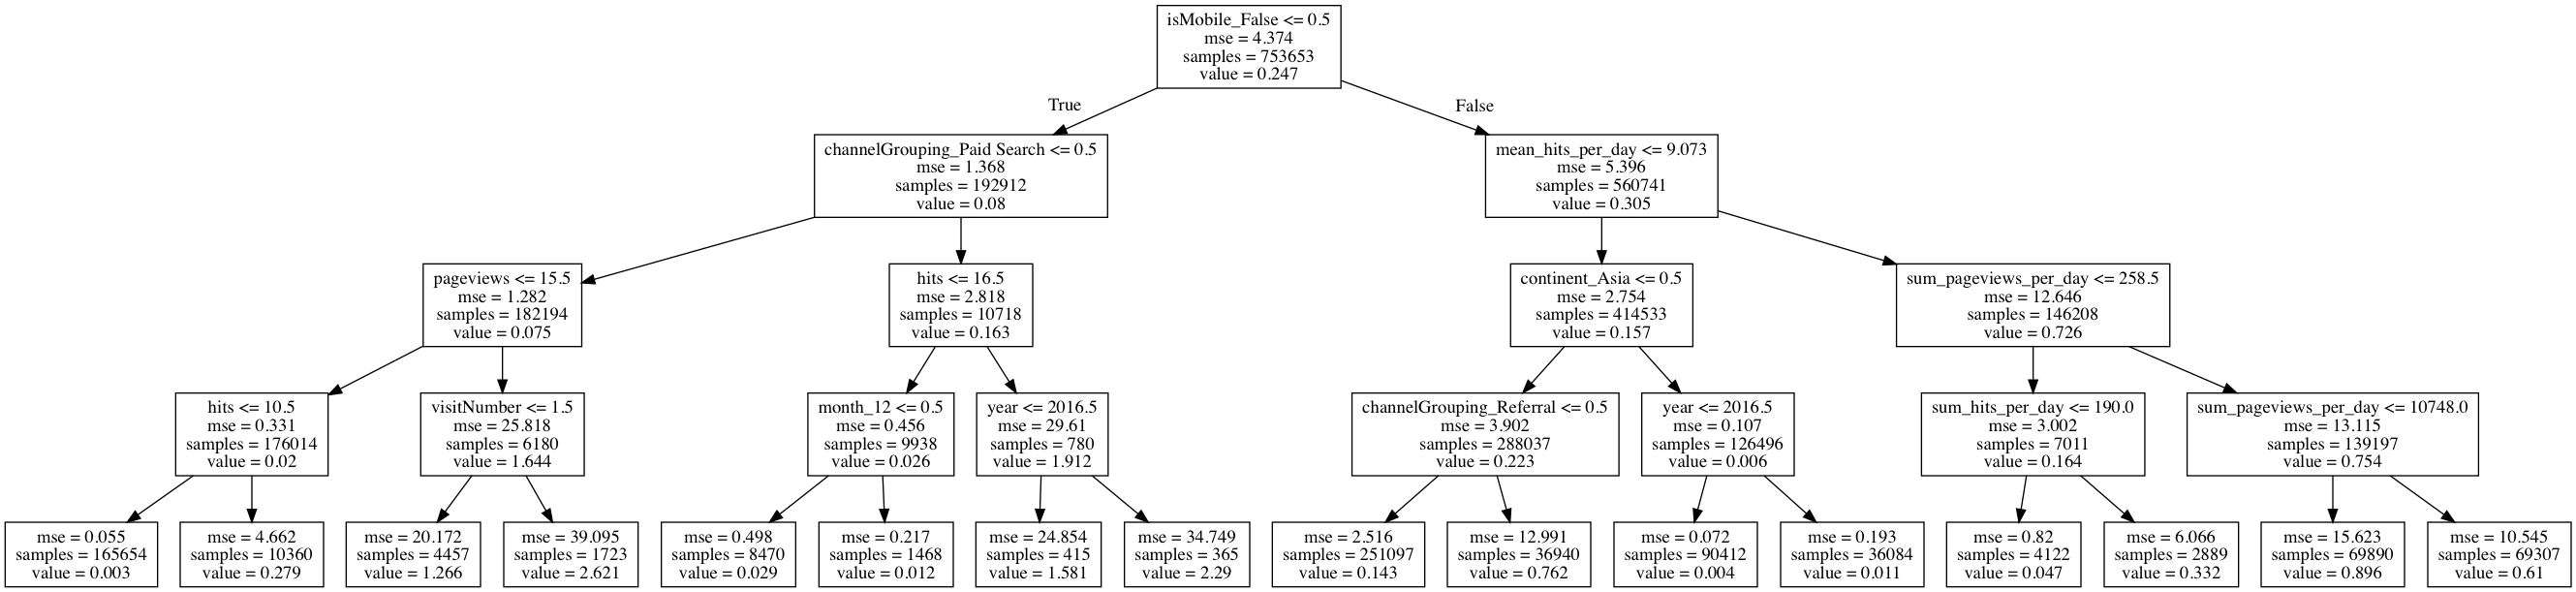

In [301]:
bin_clf_dot_data = export_graphviz(dtree,out_file=None,feature_names=X_train.columns)
bin_clf_graph = pydotplus.graph_from_dot_data(bin_clf_dot_data)
Image(bin_clf_graph.create_png())

In [156]:
from pdpbox import pdp
from plotnine import *

In [168]:
x = get_sample(X_train, 500)

In [169]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

## 5. Target Distribution Plot 

In [172]:
from plotnine import *
from pdpbox import pdp, info_plots,get_dataset

### 5.1 Page Views

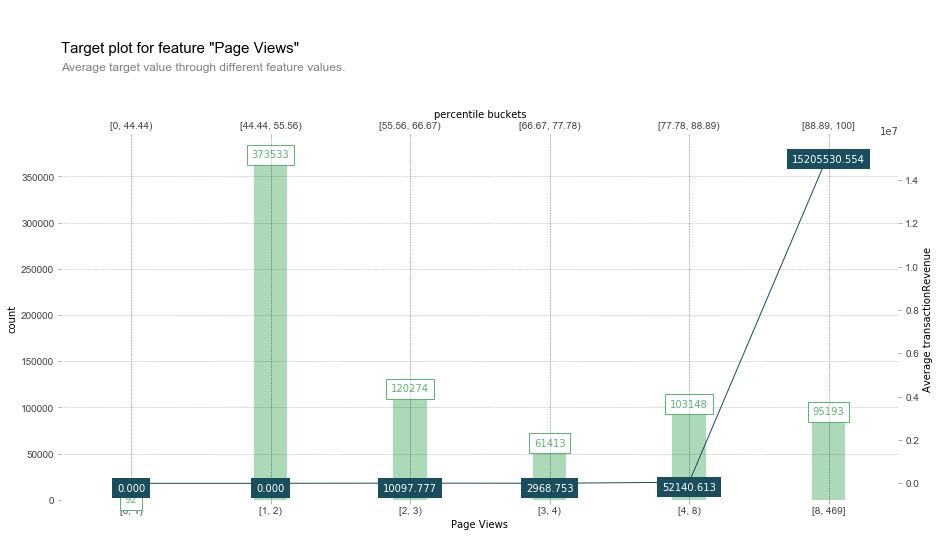

In [178]:
fig, axes, summary_df = info_plots.target_plot(
    df=x_train, feature='pageviews', feature_name='Page Views', target='transactionRevenue', show_percentile=True
)

### 5.2 Mean Hits Per Day

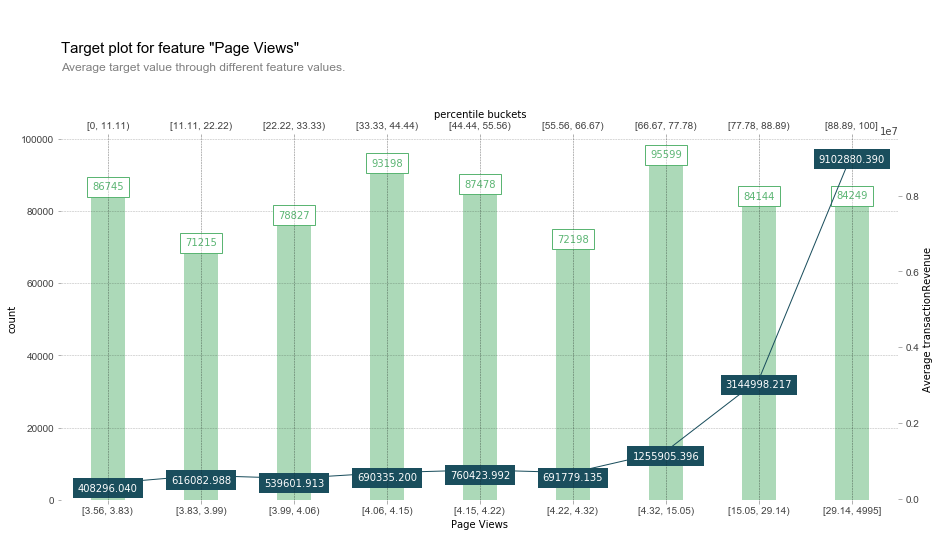

In [179]:
fig, axes, summary_df = info_plots.target_plot(
    df=x_train, feature='mean_hits_per_day', feature_name='Mean Hits Per Day', target='transactionRevenue', show_percentile=True
)

### 5.3 Continent America

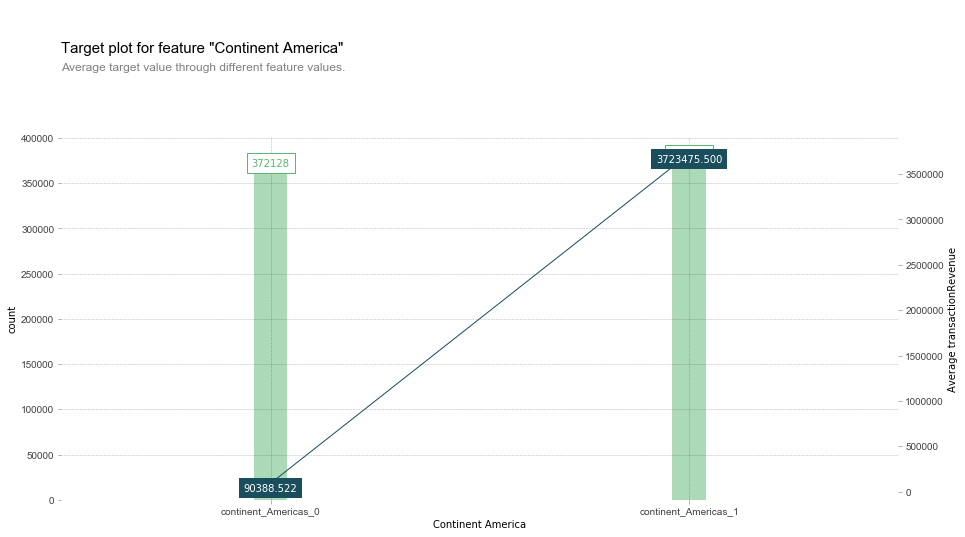

In [183]:
fig, axes, summary_df = info_plots.target_plot(
    df=x_train, feature='continent_Americas', feature_name='Continent America', target='transactionRevenue', show_percentile=True
)

## 6. Partial Dependance Plots

### 6.1 Partial Dependance for Page Views

(<matplotlib.figure.Figure at 0x1d781fd320>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c809129e8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c6d4fb208>})

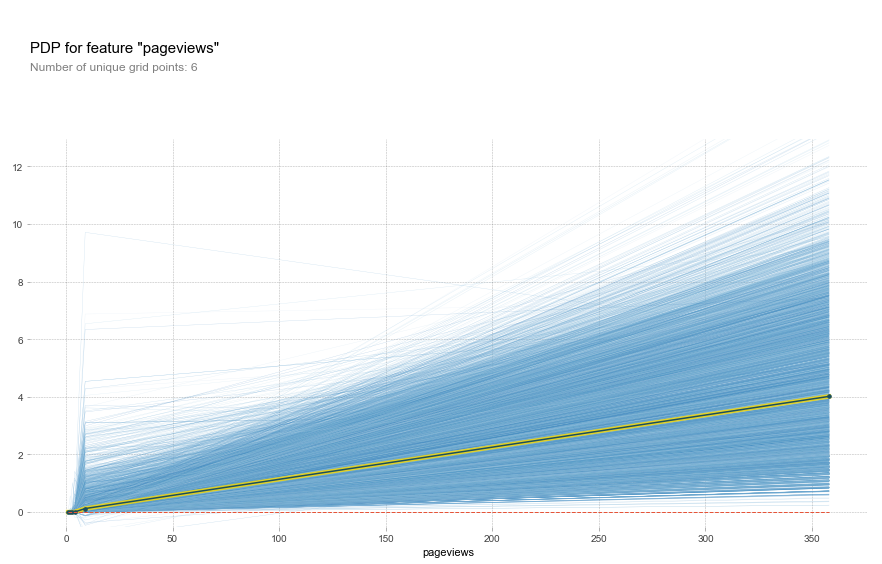

In [299]:
pdp_page_views =  pdp.pdp_isolate(model=m, dataset=x, model_features=model_features, feature='pageviews')
pdp.pdp_plot(pdp_page_views, 'pageviews', plot_lines=True)

### 6.2 Partial Dependance for Hits

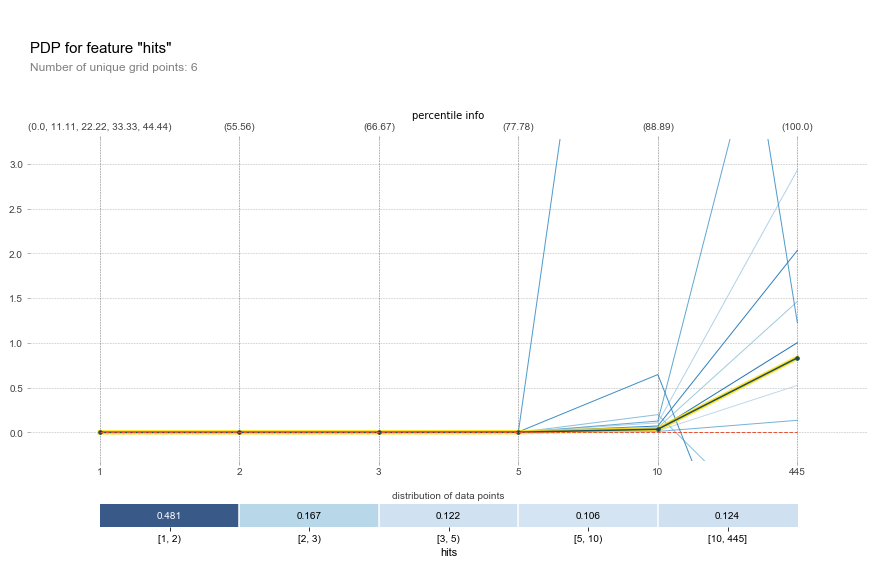

In [303]:
pdp_mean_hit =  pdp.pdp_isolate(model=m, dataset=x, model_features=model_features, feature='hits')
fig, axes = pdp.pdp_plot(
    pdp_mean_hit, 'hits', frac_to_plot=0.5, plot_lines=True, cluster=10,n_cluster_centers=10,
    x_quantile=True, show_percentile=True, plot_pts_dist=True)

### 6.3 Partial Dependance - Visit Number

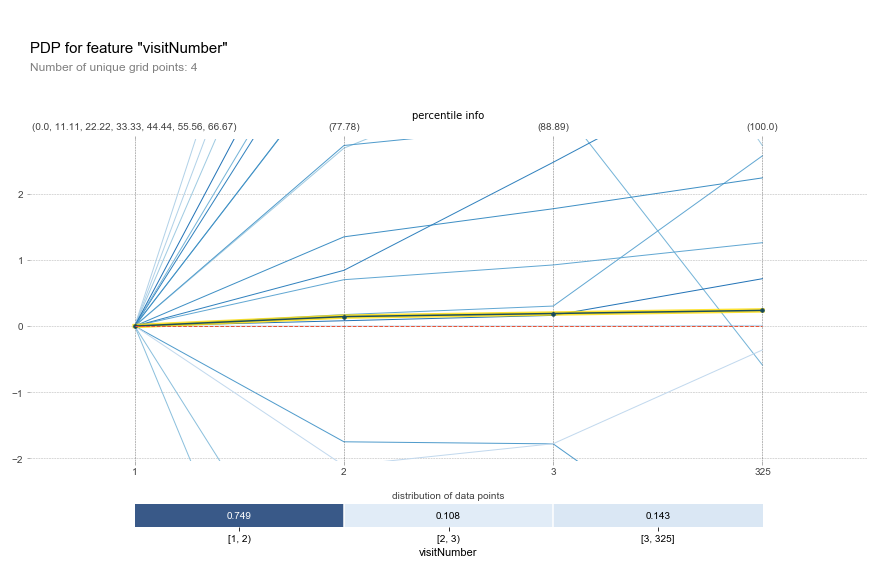

In [297]:
pdp_visit_number =  pdp.pdp_isolate(model=m, dataset=x, model_features=model_features, feature='visitNumber')
fig, axes = pdp.pdp_plot(
    pdp_visit_number, 'visitNumber', frac_to_plot=0.5, plot_lines=True, cluster=20,n_cluster_centers=20,
    x_quantile=True, show_percentile=True, plot_pts_dist=True)

## 7. Tree Interpretation

In [304]:
from treeinterpreter import treeinterpreter as ti
from tree_interp_functions import *

In [305]:
prediction, bias, contributions = ti.predict(m, X_val)

In [306]:
idxs = np.argsort(contributions[0])

#### For a specific record

In [308]:
[o for o in zip(X_train.columns[idxs], X_val.iloc[0][idxs], contributions[0][idxs])]

[('pageviews', 1.0, -0.08151349103165506),
 ('hits', 1.0, -0.05936522709602212),
 ('continent_Americas', 0.0, -0.04140007758545153),
 ('visitNumber', 1.0, -0.019187281912616132),
 ('channelGrouping_Referral', 0.0, -0.01781603082762047),
 ('mean_pageviews_per_day', 4.026854311768507, -0.007769009579695202),
 ('mean_hits_per_day', 4.759675450563654, -0.00685235720065756),
 ('continent_Asia', 1.0, -0.0059640775649328764),
 ('sum_pageviews_per_day', 56082.0, -0.005664723057456626),
 ('sum_hits_per_day', 66288.0, -0.004736993216379252),
 ('isMobile_False', 0.0, -0.002489488817693542),
 ('isMobile_True', 1.0, -0.0017364801081292092),
 ('deviceCategory_desktop', 0.0, -0.00042039588404797166),
 ('year', 2017.0, -0.00016139968410063647),
 ('weekday_0', 1.0, -0.00010242098101706474),
 ('month_2', 0.0, -6.379028090338413e-05),
 ('deviceCategory_mobile', 1.0, -5.7581162675338894e-05),
 ('month_5', 0.0, -4.5204057179957136e-05),
 ('weekday_4', 0.0, -4.3150286842633744e-05),
 ('weekday_1', 0.0, -1.6

#### Aggregated Contribution over entire data

In [310]:
feature_dict = dict((k,[]) for k in list(X_val.columns))
for i in range(len(X_val)):
    for c, feature in zip(contributions[i],list(X_val.columns)):
        feature_dict[feature].append(np.amax(c))

In [314]:
#Calculating the mean of each list 
feature_mean_dict = dict()
for feature in list(test.columns):
    feature_mean_dict[feature] = round(abs(np.mean(feature_dict[feature])),4)

sorted(feature_mean_dict.items(),key=lambda x:x[1], reverse=True)

[('visitNumber', 0.0344),
 ('pageviews', 0.0238),
 ('hits', 0.0153),
 ('channelGrouping_Referral', 0.0088),
 ('continent_Americas', 0.0087),
 ('mean_pageviews_per_day', 0.006),
 ('mean_hits_per_day', 0.0053),
 ('year', 0.0035),
 ('sum_hits_per_day', 0.003),
 ('sum_pageviews_per_day', 0.0027),
 ('month_7', 0.0025),
 ('month_4', 0.0014),
 ('weekday_4', 0.0014),
 ('medium_referral', 0.0013),
 ('weekday_2', 0.0012),
 ('month_11', 0.0011),
 ('month_12', 0.001),
 ('deviceCategory_desktop', 0.0008),
 ('weekday_6', 0.0008),
 ('isMobile_True', 0.0007),
 ('weekday_3', 0.0007),
 ('channelGrouping_Organic Search', 0.0006),
 ('continent_Asia', 0.0006),
 ('isMobile_False', 0.0006),
 ('weekday_0', 0.0006),
 ('continent_Europe', 0.0005),
 ('medium_organic', 0.0005),
 ('weekday_5', 0.0005),
 ('month_3', 0.0004),
 ('month_6', 0.0004),
 ('month_9', 0.0004),
 ('month_8', 0.0003),
 ('month_1', 0.0002),
 ('month_2', 0.0002),
 ('month_5', 0.0002),
 ('channelGrouping_Affiliates', 0.0001),
 ('channelGrouping_D

In [ ]:
get_sample(X_train, 500)

In [316]:
agg_prediction, agg_bias, agg_contributions = ti.predict(m, get_sample(X_train, 2000),joint_contribution=True)

In [317]:
def aggregated_contribution(contribution_map):
    contr_sum  = {}
    for j, dct in enumerate(contribution_map):
        for k in set(dct.keys()).union(set(contr_sum.keys())):
            contr_sum[k] = (contr_sum.get(k, 0)*j + dct.get(k,0) ) / (j+1)
    return contr_sum

#### Interaction between Variables

In [318]:
contributions_agg = aggregated_contribution(agg_contributions)

In [323]:
contributions_agg

{(6, 10, 17, 41, 42): -0.00011314870354128447,
 (17, 20): -1.8506595348156765e-05,
 (10, 17, 20, 28, 44): 4.37428513247964e-06,
 (6, 12, 17, 18, 20, 21, 41): -1.2728326701975377e-07,
 (17, 20, 41): 4.438151418444875e-05,
 (6, 10, 14, 17, 20, 41, 43, 44): -3.1205874825968883e-07,
 (10, 14, 17, 20, 21, 26, 28, 36, 41, 44, 49, 50): -2.0583994867308954e-07,
 (6, 17, 32, 43, 44): -1.2222718137415846e-06,
 (6, 20, 41): 1.3028954320920596e-05,
 (10, 14, 17, 21, 41): -7.605925002221074e-06,
 (10, 17, 20): -3.0823183305139845e-05,
 (12, 17, 42): 3.3583967380045512e-06,
 (4, 10, 14, 17, 41, 44): -2.7150784330751675e-06,
 (6, 10, 18, 41, 44): 4.22337639252418e-05,
 (6, 17, 19, 41, 42, 43, 44, 50, 51): 2.4150604208278957e-07,
 (17, 28, 42): 1.3010077618946038e-05,
 (11, 12, 19, 41, 44): 1.621073697343289e-07,
 (6, 11, 12, 21, 41): 8.315371949153547e-06,
 (10, 17, 28, 41, 43): -2.5010083584456365e-05,
 (14, 43): 9.85929859021661e-06,
 (6, 12, 17, 20, 41, 42): -1.9682844363091557e-07,
 (6, 11, 14, 2